In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from skimage import io, color, filters, morphology, measure, img_as_ubyte
from skimage.color import rgba2rgb, rgb2gray
from skimage.filters import threshold_otsu
from skimage.morphology import disk
from skimage.feature import peak_local_max
from skimage.segmentation import watershed, clear_border

from scipy import ndimage as ndi
from scipy.ndimage import binary_fill_holes



In [3]:
import pydicom
import numpy as np
import os

def load_dicom_series(folder_path):
    
    dicom_files = []

    # Load DICOM files from folder
    for filename in sorted(os.listdir(folder_path)):
        if filename.endswith('.dcm'):
            filepath = os.path.join(folder_path, filename)
            try:
                dicom_files.append(pydicom.dcmread(filepath))
            except Exception as e:
                print(f"⚠️ Warning: Could not read {filename} - {e}")

    if not dicom_files:
        raise ValueError("❌ No valid DICOM files found in the folder.")

    # Try sorting by ImagePositionPatient if available
    try:
        dicom_files.sort(key=lambda x: float(x.ImagePositionPatient[2]))
    except AttributeError:
        print("⚠️ ImagePositionPatient not found. Using default order.")

    # Stack images into a 3D NumPy array
    volume = np.stack([file.pixel_array for file in dicom_files])

    # Extract voxel spacing
    try:
        slice_thickness = float(dicom_files[0].SliceThickness)
    except AttributeError:
        slice_thickness = 1.0  # Default value if missing
        print("⚠️ SliceThickness not found. Using default value of 1.0.")

    try:
        pixel_spacing = dicom_files[0].PixelSpacing
        spacing = (slice_thickness, float(pixel_spacing[0]), float(pixel_spacing[1]))
    except AttributeError:
        spacing = (slice_thickness, 1.0, 1.0)  # Default pixel spacing
        print("⚠️ PixelSpacing not found. Using default (1.0, 1.0).")

    print(f"Loaded DICOM series: {len(dicom_files)} slices")
    print(f"Volume shape: {volume.shape}")
    print(f"Voxel spacing: {spacing}")

    return volume, spacing, dicom_files

folder_path = "/Users/shimincheng/.cache/DCMDATA/SCD_IMAGES_01/SCD0000101/CINESAX_300"
volume, spacing, dicom_files = load_dicom_series(folder_path)

Loaded DICOM series: 240 slices
Volume shape: (240, 256, 256)
Voxel spacing: (10.0, 1.367188, 1.367188)


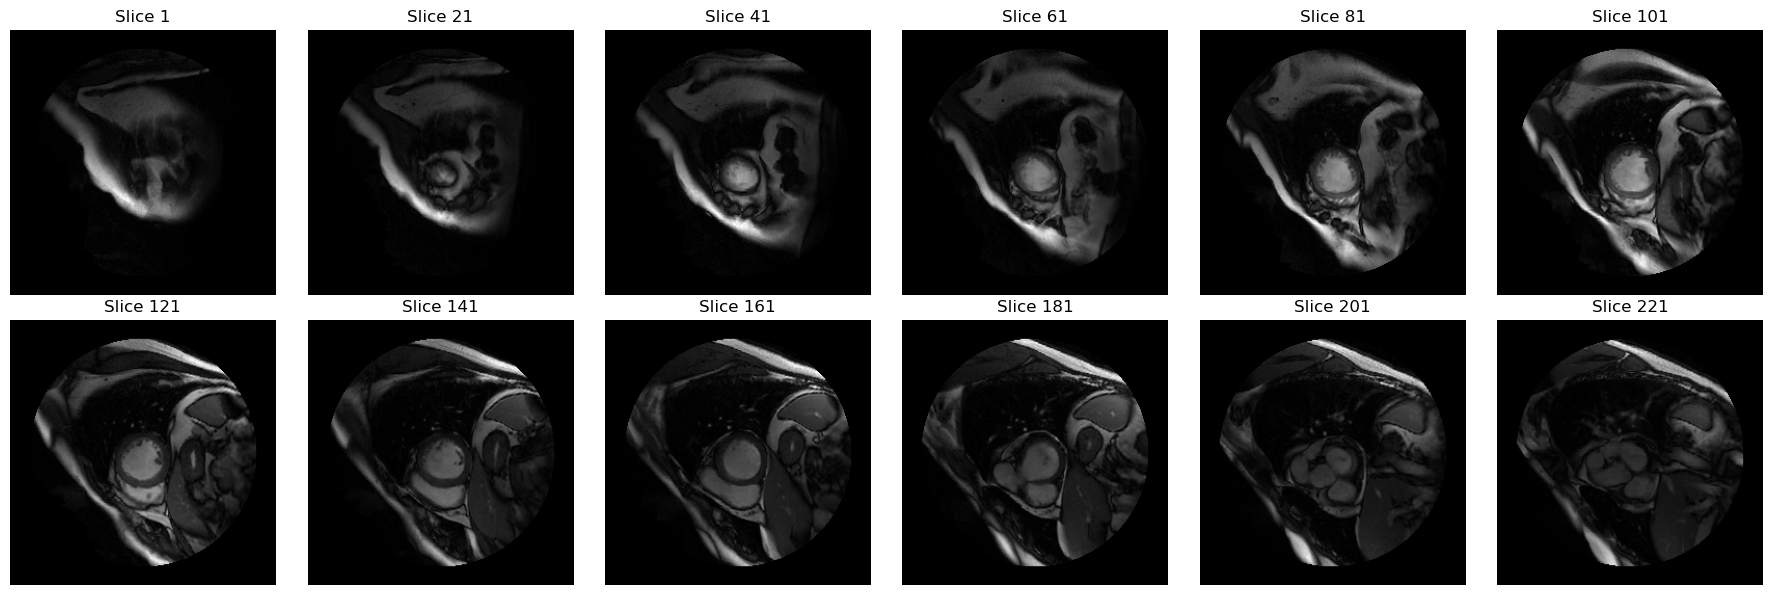

In [4]:
import matplotlib.pyplot as plt
import numpy as np

def show_slices(volume, num_columns=6, step=10):
    """
    Display selected DICOM slices in a grid format, skipping by a given step.

    Parameters:
    - volume (numpy array): 3D NumPy array containing the image stack.
    - num_columns (int): Number of columns in the figure (default: 6).
    - step (int): Step size to skip slices (default: 5).
    """
    slices = volume[::step]  # Extract slices at the given step
    num_slices = slices.shape[0]
    num_rows = int(np.ceil(num_slices / num_columns))  # Compute necessary rows

    fig, axes = plt.subplots(num_rows, num_columns, figsize=(num_columns * 3, num_rows * 3))  # Adjust figure size

    for i in range(num_rows * num_columns):
        row, col = divmod(i, num_columns)  # Get row and column index
        

        if i < num_slices:
            img = slices[i]
            #if img.ndim == 3 and img.shape[-1] == 3:
                #img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
                
            axes[row, col].imshow(img, cmap='gray')
            axes[row, col].set_title(f"Slice {i * step + 1}", fontsize=12)  # Adjusted index
            axes[row, col].axis("off")
        else:
            axes[row, col].axis("off")  # Hide unused subplots

    plt.tight_layout()
    plt.show()

# Example usage:
show_slices(volume, num_columns=6, step=20)

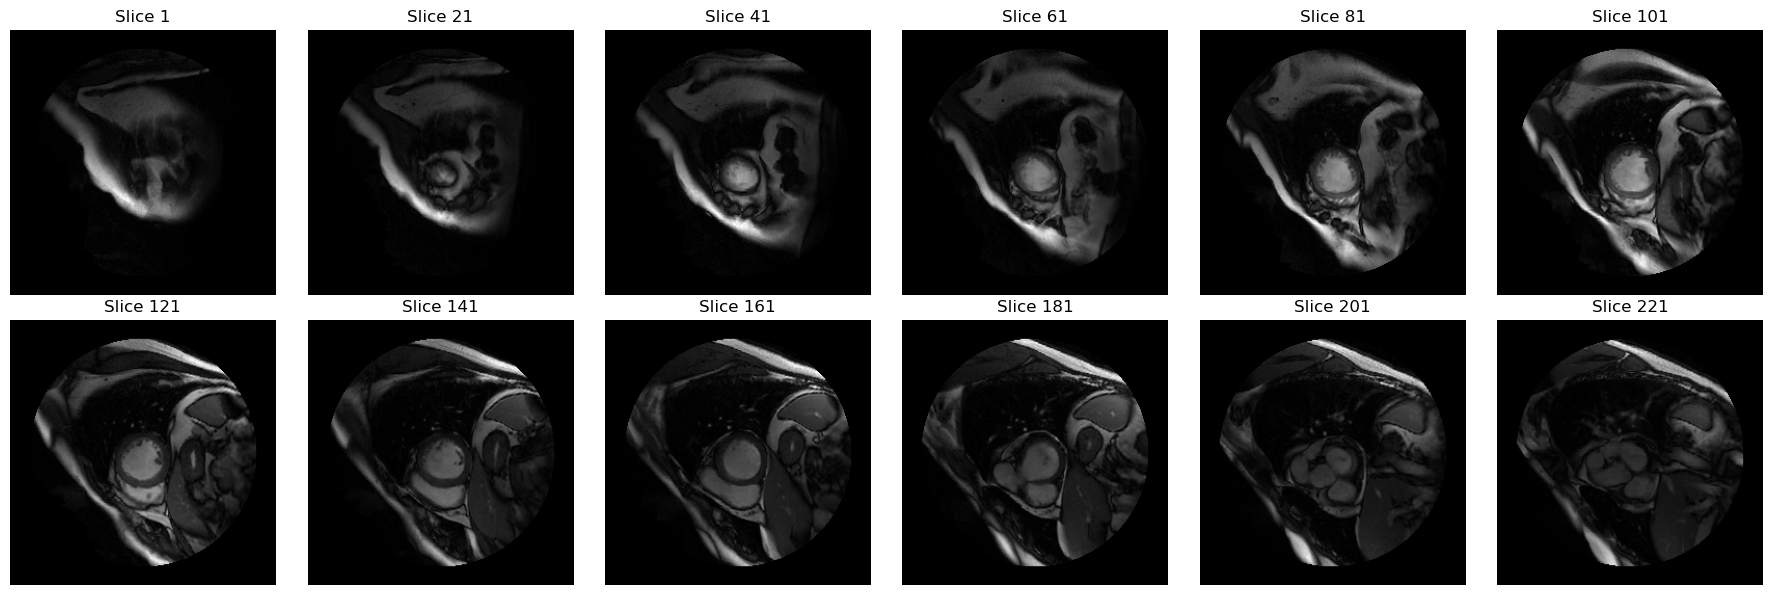

In [5]:
import numpy as np
import cv2

def convert_volume_to_grayscale(volume):
    """
    Convert a 3D volume to grayscale (if needed).

    Parameters:
    - volume: 3D NumPy array (D, H, W) or (D, H, W, C)

    Returns:
    - gray_volume: 3D NumPy array (D, H, W), grayscale version
    """
    gray_volume = []

    for i in range(volume.shape[0]):
        img = volume[i]
        if img.ndim == 3 and img.shape[-1] == 3:
            img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray_volume.append(img)

    return np.stack(gray_volume)


gray_volume = convert_volume_to_grayscale(volume)

show_slices(gray_volume, num_columns=6, step=20)

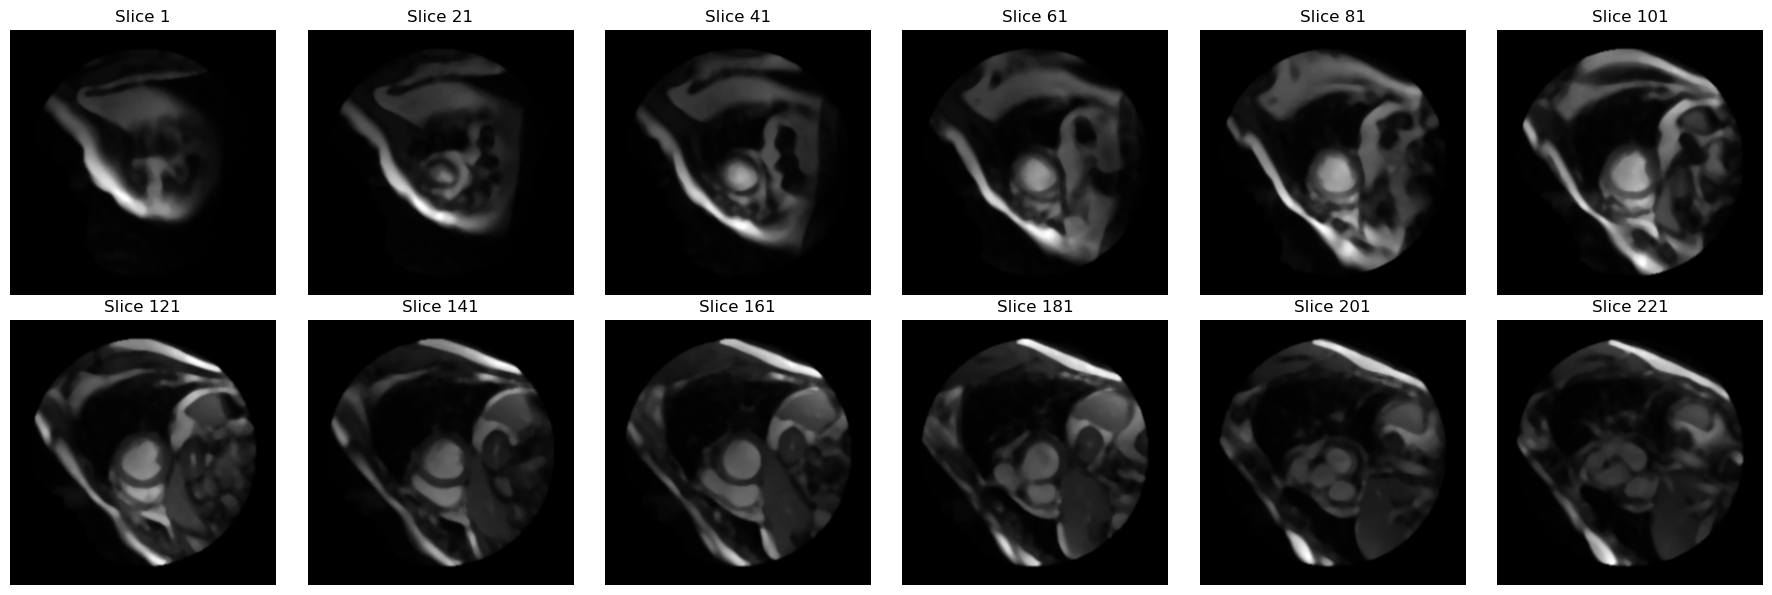

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
def smoothed_volume(volume):
    gauss_volume = []

    for i in range(volume.shape[0]):
        img = volume[i]

        if img.dtype != np.uint8:
            img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)  
            img = img.astype(np.uint8)

        med = cv2.medianBlur(img, 7)
        gauss = cv2.GaussianBlur(med, (3, 3), 0)
        gauss_volume.append(gauss)

    return np.stack(gauss_volume)



smoothed = smoothed_volume(gray_volume)

show_slices(smoothed, num_columns=6, step=20)

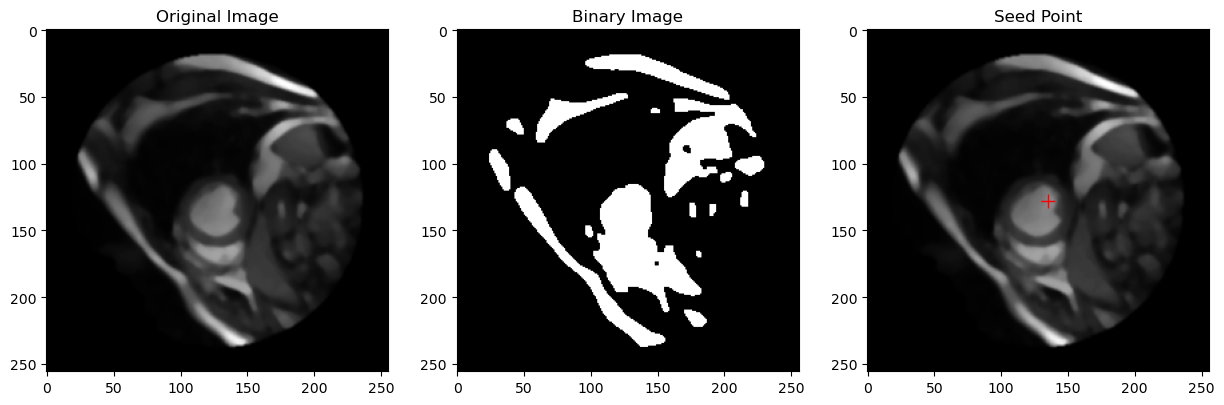

In [51]:
def find_lv_seed_point(binary_img):
    """
    在二值图像中找到可能的左心室种子点，偏向左侧且稍微向上
    返回: (y, x) 坐标
    """
   
    h, w = binary_img.shape
    center_y, center_x = h // 2, w // 2
    roi_size = min(h, w) // 4
    
   
    roi_left_offset = w // 8  
    roi_up_offset = h // 12   
    
    roi_x_start = max(center_x - roi_size - roi_left_offset, 0)
    roi_x_end = min(center_x + roi_size - roi_left_offset, w)
    roi_y_start = max(center_y - roi_size - roi_up_offset, 0)
    roi_y_end = min(center_y + roi_size - roi_up_offset, h)
    
  
    roi = binary_img[roi_y_start:roi_y_end, roi_x_start:roi_x_end]
    
   
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(roi)
    
    if num_labels > 1: 
        # 
        max_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
     
        seed_y, seed_x = centroids[max_label]
     
        seed_y = roi_y_start + seed_y - roi_size//6  
        seed_x += roi_x_start
        return (int(seed_y), int(seed_x))
    else:
      
        return (center_y - roi_up_offset, center_x - roi_left_offset)


def visualize_preprocessing(original, binary, seed_point):
    
    plt.figure(figsize=(15, 5))
    
    plt.subplot(131)
    plt.imshow(original, cmap='gray')
    plt.title('Original Image')
    
    plt.subplot(132)
    plt.imshow(binary, cmap='gray')
    plt.title('Binary Image')
    
    plt.subplot(133)
    plt.imshow(original, cmap='gray')
    plt.plot(seed_point[1], seed_point[0], 'r+', markersize=10)
    plt.title('Seed Point')
    
    plt.show()

# 选择中间切片进行处理
middle_slice = smoothed[smoothed.shape[0]//2]
binary_slice = preprocess_slice_for_lv(middle_slice)
seed_point = find_lv_seed_point(binary_slice)

# 可视化结果
visualize_preprocessing(middle_slice, binary_slice, seed_point)

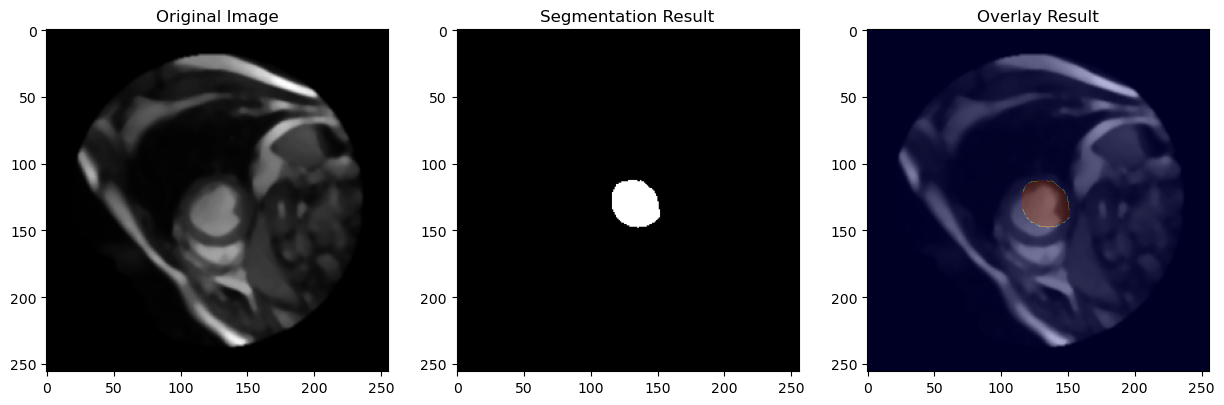

In [58]:
def region_growing(img, seed_point, threshold=30, max_iterations=1000):
   
    img = img.astype(float)
    
  
    segmentation = np.zeros_like(img, dtype=np.uint8)
    segmentation[seed_point[0], seed_point[1]] = 1
    
 
    neighbors = [(0,1), (1,0), (0,-1), (-1,0), 
                (1,1), (1,-1), (-1,1), (-1,-1)]
    
   
    seed_intensity = img[seed_point[0], seed_point[1]]
    
  
    intensity_range = np.max(img) - np.min(img)
    

    center_y, center_x = img.shape[0] // 2, img.shape[1] // 2
    
 
    expected_radius = 20
    
    
    for _ in range(max_iterations):
       
        kernel = np.ones((3,3), np.uint8)
        dilated = cv2.dilate(segmentation, kernel, iterations=1)
        boundary = dilated - segmentation
        
        
        if np.sum(boundary) == 0:
            break
            

        boundary_points = np.where(boundary > 0)
        boundary_points = list(zip(boundary_points[0], boundary_points[1]))
        
     
        for y, x in boundary_points:
         
            dist_from_seed = np.sqrt((y - seed_point[0])**2 + (x - seed_point[1])**2)
            
            
            if dist_from_seed > expected_radius:
                continue
                
         
            for dy, dx in neighbors:
                new_y, new_x = y + dy, x + dx
                
               
                if (new_y < 0 or new_y >= img.shape[0] or 
                    new_x < 0 or new_x >= img.shape[1]):
                    continue
                    
             
                if segmentation[new_y, new_x] == 1:
                    continue
                
                
                new_dist_from_seed = np.sqrt((new_y - seed_point[0])**2 + (new_x - seed_point[1])**2)
                if new_dist_from_seed > expected_radius:
                    continue
                
           
                current_intensity = img[new_y, new_x]
                
                
                intensity_diff = abs(current_intensity - seed_intensity) / intensity_range
                
           
                is_darker = current_intensity <= seed_intensity * 1.1
                
               
                if intensity_diff < threshold/200 and is_darker:
                    segmentation[new_y, new_x] = 1
    

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
    segmentation = cv2.morphologyEx(segmentation, cv2.MORPH_CLOSE, kernel)
    segmentation = cv2.morphologyEx(segmentation, cv2.MORPH_OPEN, kernel)
    
   
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(segmentation)
    if num_labels > 2:  
        max_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
        segmentation = (labels == max_label).astype(np.uint8)
    
    return segmentation


segmentation = region_growing(middle_slice, seed_point, threshold=80)  # 使用更小的阈值


visualize_segmentation(middle_slice, segmentation)

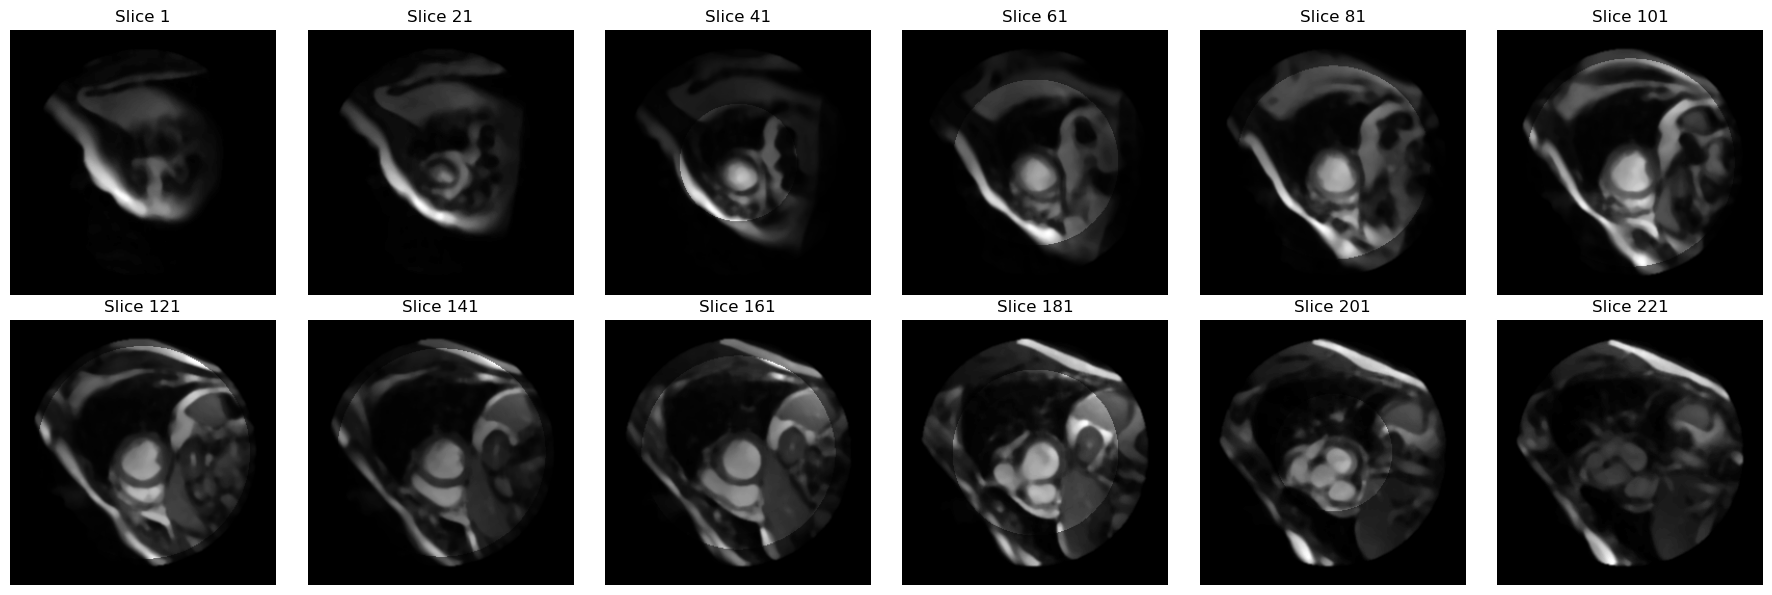

In [ ]:
def center_weighted_volume(volume, alpha, center_weight=10.0, weight_range=0.8, edge_darkening=0.7):
    """
    Apply center weighting and edge darkening to a volume (2D or 3D)
    
    Args:
        volume: Input 2D or 3D volume
        alpha: Scaling factor for intensity enhancement
        center_weight: Weight for central region enhancement
        weight_range: Range of the weighting effect (0-1)
        edge_darkening: Factor to darken edges (0-1)
    """
    if len(volume.shape) == 2:
        # Handle 2D image
        img = volume.copy().astype(float)
        h, w = img.shape
        
        # Create coordinate grids
        yy, xx = np.meshgrid(np.linspace(-1, 1, w), np.linspace(-1, 1, h))
        distance = np.sqrt(xx**2 + yy**2)
        
        # Create smooth weight map using sigmoid
        weight_map = 1 / (1 + np.exp(-center_weight * (weight_range - distance)))
        
        # Normalize weight map
        weight_map = (weight_map - weight_map.min()) / (weight_map.max() - weight_map.min())
        
        # Apply center weighting
        img_weighted = img * (1 + alpha * weight_map)
        
        # Apply edge darkening
        edge_mask = distance > weight_range
        img_weighted = img_weighted * (1 - edge_darkening * edge_mask)
        
        # Ensure values stay within original range
        img_weighted = np.clip(img_weighted, img.min(), img.max())
        
        return img_weighted.astype(volume.dtype)
    else:
        # Handle 3D volume
        weighted = np.copy(volume).astype(float)
        depth, height, width = volume.shape
        
        # Create coordinate grids
        z, y, x = np.ogrid[:depth, :height, :width]
        
        # Calculate distances from center
        center_z, center_y, center_x = depth//2, height//2, width//2
        dist_from_center = np.sqrt(((z - center_z)/(depth/2))**2 + 
                                  ((y - center_y)/(height/2))**2 + 
                                  ((x - center_x)/(width/2))**2)
        
        # Create center weights using sigmoid for smoother transition
        center_weights = 1 / (1 + np.exp(-center_weight * (weight_range - dist_from_center)))
        center_weights = (center_weights - center_weights.min()) / (center_weights.max() - center_weights.min())
        
        # Create edge weights (inverse of center weights)
        edge_weights = 1 - edge_darkening * (dist_from_center > weight_range)
        
        # Apply both weightings
        weighted = weighted * (1 + alpha * center_weights) * edge_weights
        
        # Normalize to original range
        weighted = weighted * (np.max(volume) / np.max(weighted))
        
        return weighted.astype(volume.dtype)


weighted = center_weighted_volume(smoothed, alpha=0.5, center_weight=4.0, weight_range=0.8, edge_darkening=0.5)


show_slices(weighted, num_columns=6, step=20)

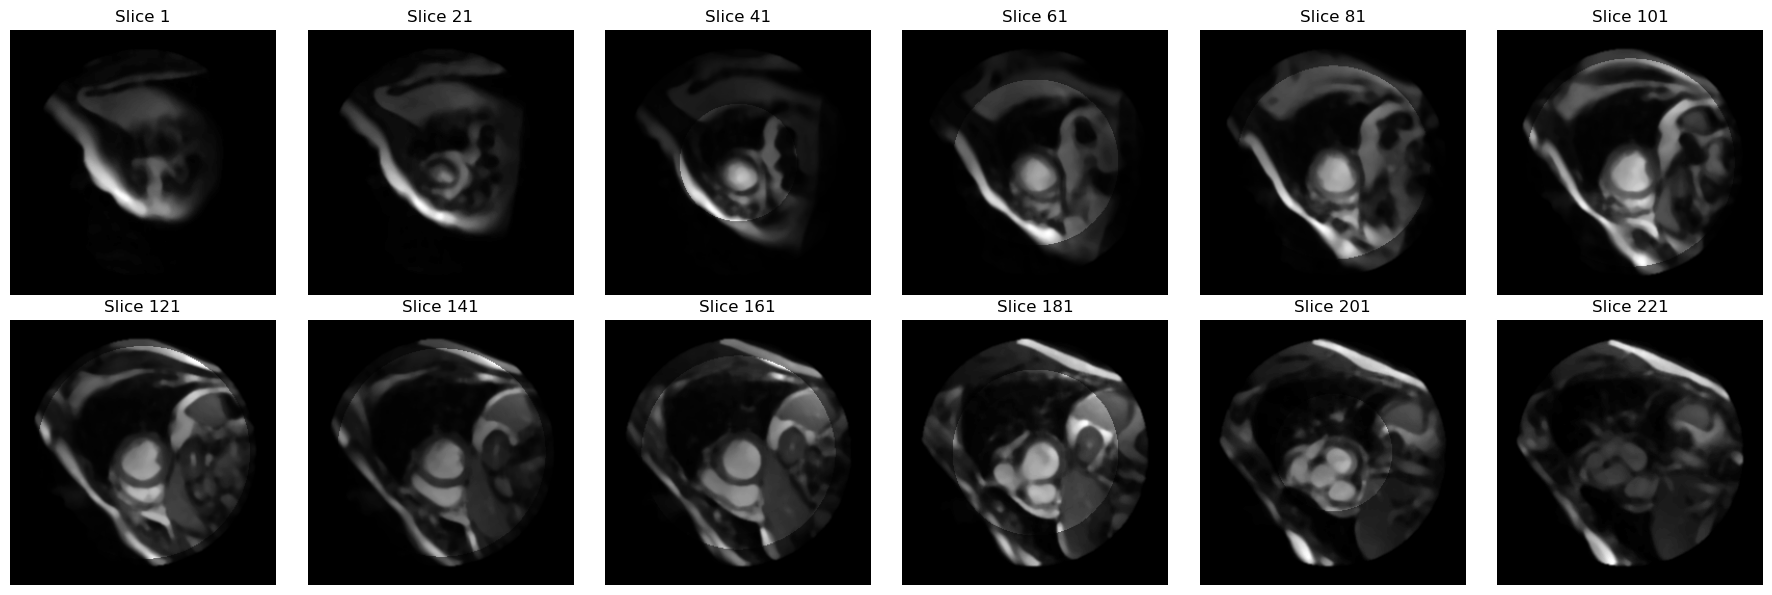

In [ ]:
def center_weighted_volume(volume, alpha, center_weight=10.0, weight_range=0.8, edge_darkening=0.7):
    """
    Apply center weighting and edge darkening to a volume (2D or 3D)
    
    Args:
        volume: Input 2D or 3D volume
        alpha: Scaling factor for intensity enhancement
        center_weight: Weight for central region enhancement
        weight_range: Range of the weighting effect (0-1)
        edge_darkening: Factor to darken edges (0-1)
    """
    if len(volume.shape) == 2:
        # Handle 2D image
        img = volume.copy().astype(float)
        h, w = img.shape
        
        # Create coordinate grids
        yy, xx = np.meshgrid(np.linspace(-1, 1, w), np.linspace(-1, 1, h))
        distance = np.sqrt(xx**2 + yy**2)
        
        # Create smooth weight map using sigmoid
        weight_map = 1 / (1 + np.exp(-center_weight * (weight_range - distance)))
        
        # Normalize weight map
        weight_map = (weight_map - weight_map.min()) / (weight_map.max() - weight_map.min())
        
        # Apply center weighting
        img_weighted = img * (1 + alpha * weight_map)
        
        # Apply edge darkening
        edge_mask = distance > weight_range
        img_weighted = img_weighted * (1 - edge_darkening * edge_mask)
        
        # Ensure values stay within original range
        img_weighted = np.clip(img_weighted, img.min(), img.max())
        
        return img_weighted.astype(volume.dtype)
    else:
        # Handle 3D volume
        weighted = np.copy(volume).astype(float)
        depth, height, width = volume.shape
        
        # Create coordinate grids
        z, y, x = np.ogrid[:depth, :height, :width]
        
        # Calculate distances from center
        center_z, center_y, center_x = depth//2, height//2, width//2
        dist_from_center = np.sqrt(((z - center_z)/(depth/2))**2 + 
                                  ((y - center_y)/(height/2))**2 + 
                                  ((x - center_x)/(width/2))**2)
        
        # Create center weights using sigmoid for smoother transition
        center_weights = 1 / (1 + np.exp(-center_weight * (weight_range - dist_from_center)))
        center_weights = (center_weights - center_weights.min()) / (center_weights.max() - center_weights.min())
        
        # Create edge weights (inverse of center weights)
        edge_weights = 1 - edge_darkening * (dist_from_center > weight_range)
        
        # Apply both weightings
        weighted = weighted * (1 + alpha * center_weights) * edge_weights
        
        # Normalize to original range
        weighted = weighted * (np.max(volume) / np.max(weighted))
        
        return weighted.astype(volume.dtype)


weighted = center_weighted_volume(smoothed, alpha=0.5, center_weight=4.0, weight_range=0.8, edge_darkening=0.5)


show_slices(weighted, num_columns=6, step=20)

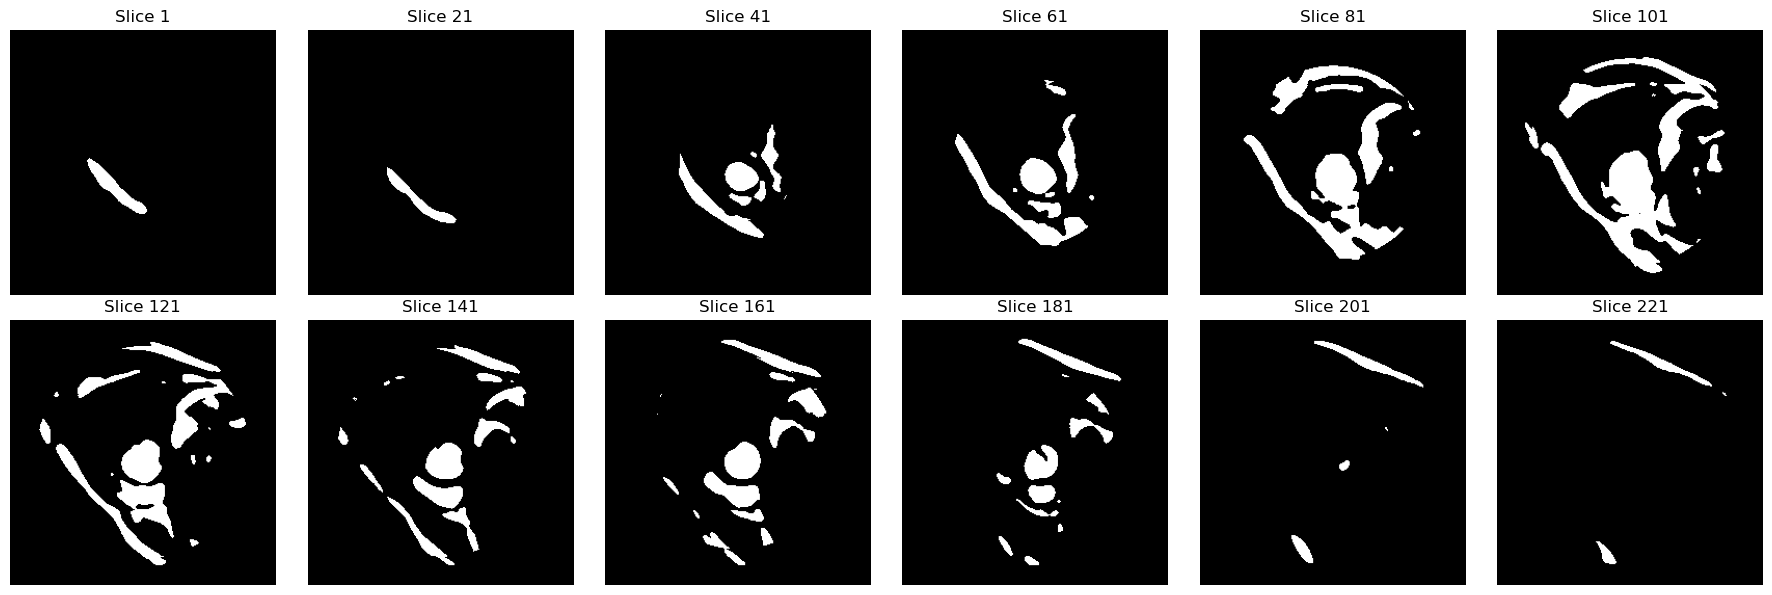

In [ ]:
import numpy as np
from skimage.filters import threshold_otsu
from skimage.measure import label
from skimage.segmentation import clear_border

import numpy as np
from skimage.filters import threshold_otsu

def threshed_volume(volume, manual_thresh):
    threshed_volume = []

    for i in range(volume.shape[0]):
        img = volume[i]

        if manual_thresh > 0:
            thresh = manual_thresh
        else:
            thresh = threshold_otsu(img)  
        
        binary = img > thresh
        binary = binary.astype(np.uint8)
        threshed_volume.append(binary)

    return np.stack(threshed_volume)


threshed = threshed_volume(weighted, manual_thresh=60)


show_slices(threshed, num_columns=6, step=20)

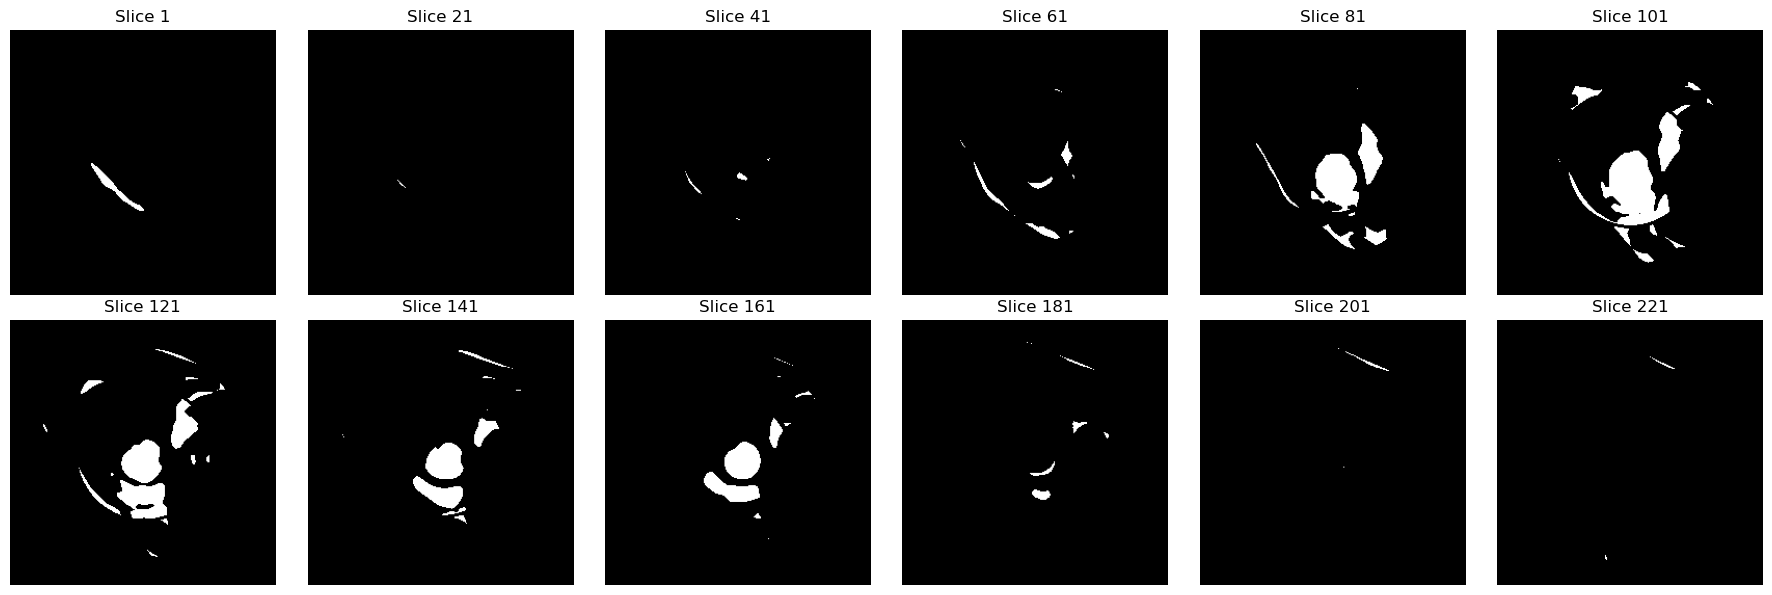

In [33]:
from skimage.morphology import erosion, dilation, ball

def disconnect_center_edges(binary_volume, radius=3):
    """
    Disconnect the center region from edges while preserving center size
    
    Args:
        binary_volume: Input binary volume
        radius: Radius of the structuring element for erosion
    
    Returns:
        Processed binary volume with disconnected center and edges
    """
    # Create a spherical structuring element
    se = ball(radius)
    
    # First perform erosion to create gaps
    eroded = erosion(binary_volume, se)
    
    # Create center mask
    center_mask = np.zeros_like(binary_volume)
    z, y, x = np.ogrid[:binary_volume.shape[0], :binary_volume.shape[1], :binary_volume.shape[2]]
    center_z, center_y, center_x = binary_volume.shape[0]//2, binary_volume.shape[1]//2, binary_volume.shape[2]//2
    dist_from_center = np.sqrt(((z - center_z)/(binary_volume.shape[0]/2))**2 + 
                              ((y - center_y)/(binary_volume.shape[1]/2))**2 + 
                              ((x - center_x)/(binary_volume.shape[2]/2))**2)
    center_mask[dist_from_center < 0.5] = 1
    
    # Get the center region from original volume
    center_region = binary_volume * center_mask
    
    # Get the edge region
    edge_region = binary_volume * (1 - center_mask)
    
    # Apply erosion only to edge region
    eroded_edges = erosion(edge_region, se)
    
    # Combine center region with eroded edges
    result = center_region + eroded_edges
    
    return result


disconnected = disconnect_center_edges(threshed, radius=3)


show_slices(disconnected, num_columns=6, step=20)

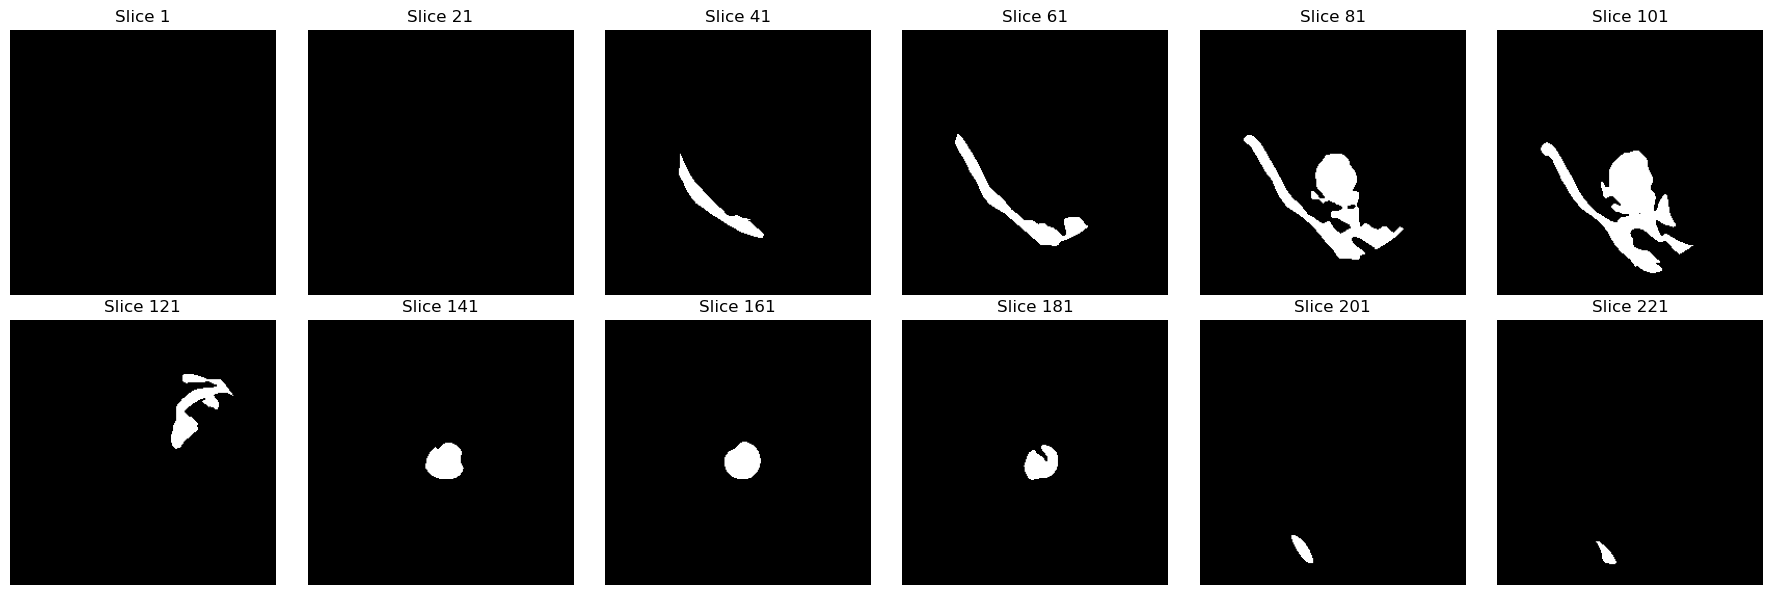

In [32]:
def keep_largest_component(binary_volume):
    """
    Keep only the largest connected component in each slice
    """
    processed_volume = []
    
    for i in range(binary_volume.shape[0]):
        img = binary_volume[i]
        
        # Label connected components
        labeled = label(img)
        
        # Find properties of connected components
        unique_labels, counts = np.unique(labeled[labeled > 1], return_counts=True)
        
        if len(counts) > 0:
            # Find the label of the largest component
            largest_label = unique_labels[np.argmax(counts)]
            
            # Keep only the largest component
            binary_mask = (labeled == largest_label).astype(np.uint8)
        else:
            binary_mask = np.zeros_like(img)
            
        processed_volume.append(binary_mask)
    
    return np.stack(processed_volume)

# Process the thresholded volume to keep only the largest component
threshed_largest = keep_largest_component(threshed)

# Show results
show_slices(threshed_largest, num_columns=6, step=20)

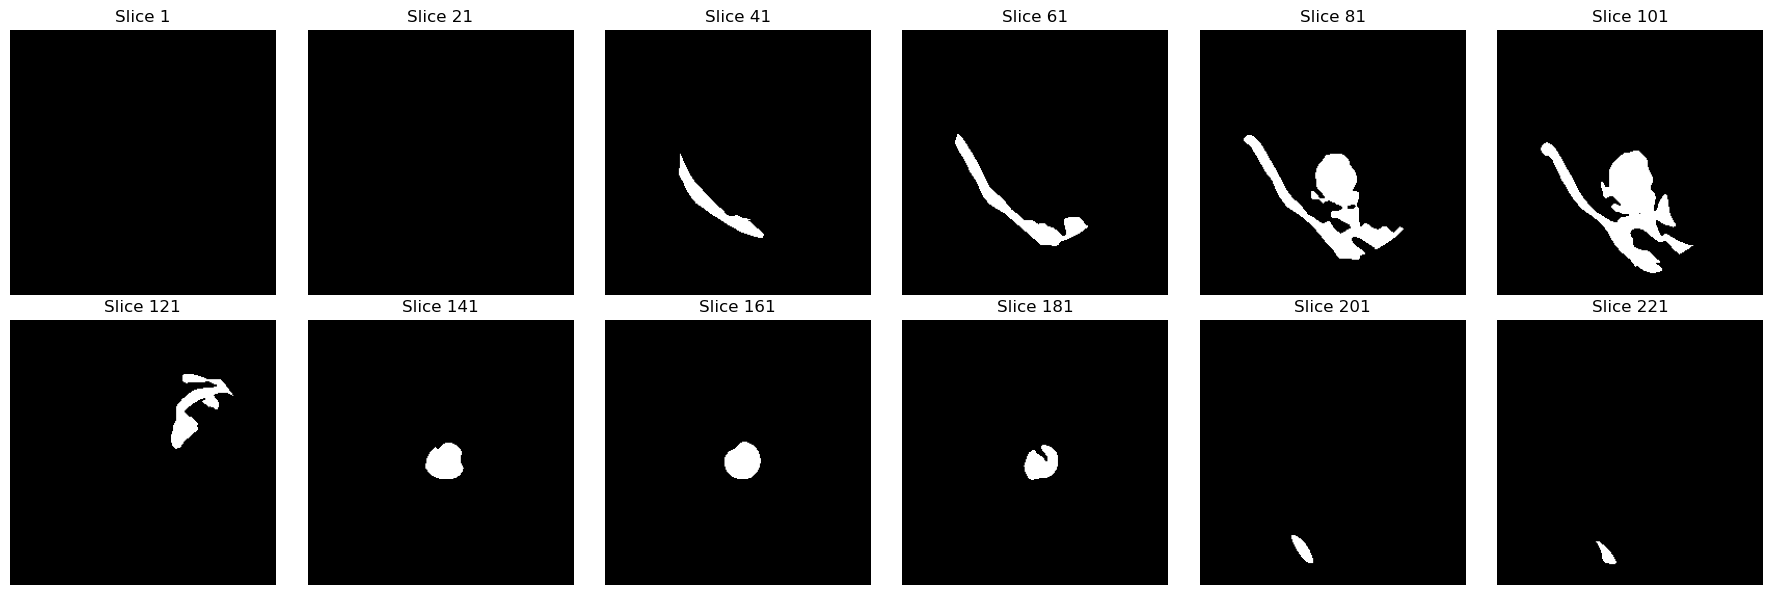

In [35]:
import numpy as np
import cv2
from skimage.filters import sobel  # This gives you direct access to the sobel function
from skimage.segmentation import watershed
from scipy.ndimage import distance_transform_edt
def watershed_volume(volume):
    watershed_volume = []

    for i in range(volume.shape[0]):
        img = volume[i]

        if np.sum(img) == 0:
            watershed_volume.append(np.zeros_like(img, dtype=np.int32))
            continue

        edges = sobel(img)
        distance_map = distance_transform_edt(img)
        
        seed_threshold = 0.4 * np.max(distance_map)
        seeds = distance_map > seed_threshold
        markers = label(seeds)
        
        labeled_mask = watershed(edges, markers, mask=img)
        watershed_volume.append(labeled_mask)

    return np.stack(watershed_volume)




watershed_result = watershed_volume(threshed)
show_slices(threshed_largest, num_columns=6, step=20)